In [104]:
from google.colab import files
uploaded = files.upload()

Saving VNM.csv to VNM.csv


In [119]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [120]:
df = pd.read_csv('VNM.csv')
df["Price"] = df["Price"].str.replace(',', '').astype(float)
df1=df.reset_index()['Price']

In [121]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1># 4. Split the data into training, testing, and validation arcording to 7:2:1

In [122]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [123]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [124]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [125]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [126]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [127]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 43ms/step - loss: 0.8093 - val_loss: 0.1609
Epoch 2/100
13/13 [==============================] - 0s 27ms/step - loss: 0.0411 - val_loss: 0.0080
Epoch 3/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0101 - val_loss: 0.0118
Epoch 4/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0082 - val_loss: 0.0045
Epoch 5/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 6/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 7/100
13/13 [==============================] - 0s 33ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 8/100
13/13 [==============================] - 1s 45ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 9/100
13/13 [==============================] - 1s 45ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 10/100
13/13 [==============================] - 1s 43ms/step - loss: 0.0036 - val_loss: 0.0026

In [128]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 25ms/step


In [129]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [130]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)


Validation RMSE: 1105.785460975802
Testing RMSE: 1313.3486536186617
Validate MAE:  862.5094506048382
Test MAE:  1007.7663869598764
Validate MAPE:  1.3062694038842413
Test MAPE:  1.447954971091569


In [131]:
# 13. Dự báo 90 ngày tiếp theo
x_input=val_data[32:].reshape(1,-1)
x_input.shape
print(len(val_data))
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


132
[0.15336625]
101
1 day input [0.18257135 0.17154416 0.16970474 0.15867756 0.16602964 0.15316303
 0.14948792 0.15684    0.15132548 0.15684    0.16786719 0.17338171
 0.16235267 0.15500059 0.14765037 0.14948792 0.14948792 0.14765037
 0.14948792 0.15867756 0.15684    0.16786719 0.16051511 0.16051511
 0.16051511 0.20462758 0.23954856 0.23219648 0.22852137 0.2340359
 0.22300685 0.22300685 0.24138612 0.24506309 0.24138612 0.23219648
 0.24138612 0.25976724 0.23771101 0.24138612 0.20462758 0.21014211
 0.20462758 0.21933174 0.21381722 0.19892316 0.18216735 0.18030559
 0.1840291  0.19147613 0.18030559 0.1709968  0.17844383 0.17844383
 0.17844383 0.17658207 0.16541153 0.1709968  0.15982626 0.18775262
 0.18216735 0.16541153 0.16541153 0.16168802 0.1579645  0.15982626
 0.12631463 0.10955882 0.11328233 0.11328233 0.10955882 0.10025003
 0.10955882 0.12259112 0.12817639 0.13562342 0.13934693 0.14307045
 0.1840291  0.18216735 0.1579645  0.15610275 0.14307045 0.15610275
 0.16541153 0.16913505 0.16541

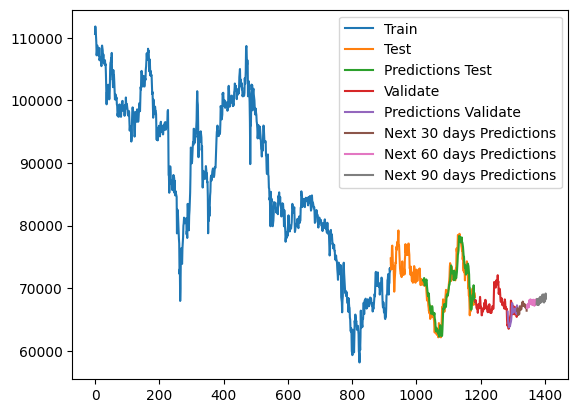

In [133]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()

<h1># 4. Split the data into training, testing, and validation arcording to 5:3:2

In [134]:
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [135]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [136]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [137]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [138]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [139]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 2s 54ms/step - loss: 0.0323 - val_loss: 0.0096
Epoch 2/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 3/100
9/9 [==============================] - 0s 31ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 4/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 5/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 6/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 7/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 8/100
9/9 [==============================] - 0s 31ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 10/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 11/100
9/9 [=

In [140]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 8ms/step


In [141]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [142]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 1595.1090034431747
Testing RMSE: 1832.9127709019435
Validate MAE:  1393.1771041027598
Test MAE:  1489.4329351535832
Validate MAPE:  2.066530069409534
Test MAPE:  2.177525907546772


In [143]:
# 13. Dự báo 90 ngày tiếp theo

x_input=val_data[164:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]

n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.17657766]
101
1 day input [0.18257135 0.17154416 0.16970474 0.15867756 0.16602964 0.15316303
 0.14948792 0.15684    0.15132548 0.15684    0.16786719 0.17338171
 0.16235267 0.15500059 0.14765037 0.14948792 0.14948792 0.14765037
 0.14948792 0.15867756 0.15684    0.16786719 0.16051511 0.16051511
 0.16051511 0.20462758 0.23954856 0.23219648 0.22852137 0.2340359
 0.22300685 0.22300685 0.24138612 0.24506309 0.24138612 0.23219648
 0.24138612 0.25976724 0.23771101 0.24138612 0.20462758 0.21014211
 0.20462758 0.21933174 0.21381722 0.19892316 0.18216735 0.18030559
 0.1840291  0.19147613 0.18030559 0.1709968  0.17844383 0.17844383
 0.17844383 0.17658207 0.16541153 0.1709968  0.15982626 0.18775262
 0.18216735 0.16541153 0.16541153 0.16168802 0.1579645  0.15982626
 0.12631463 0.10955882 0.11328233 0.11328233 0.10955882 0.10025003
 0.10955882 0.12259112 0.12817639 0.13562342 0.13934693 0.14307045
 0.1840291  0.18216735 0.1579645  0.15610275 0.14307045 0.15610275
 0.16541153 0.16913505 0.16541153 

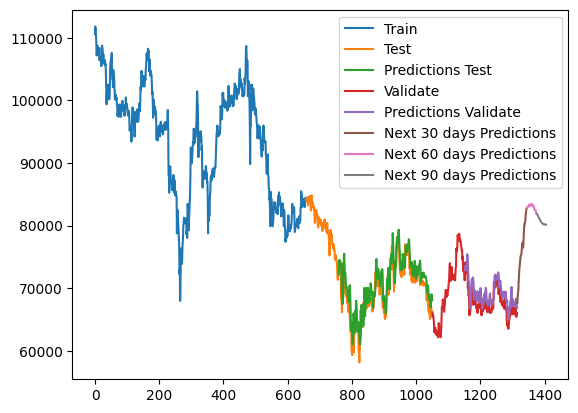

In [144]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+30, stop=len(df1)+60, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+60, stop=len(df1)+90, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()


<h1># 4. Split the data into training, testing, and validation arcording to 6:3:1

In [157]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [158]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [159]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [160]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [161]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [162]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 2s 46ms/step - loss: 0.0715 - val_loss: 0.0190
Epoch 2/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0229 - val_loss: 0.0536
Epoch 3/100
11/11 [==============================] - 0s 24ms/step - loss: 0.0116 - val_loss: 0.0143
Epoch 4/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 5/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 6/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 7/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 9.3657e-04
Epoch 9/100
11/11 [==============================] - 0s 24ms/step - loss: 0.0014 - val_loss: 8.9833e-04
Epoch 10/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0014 - val_loss

In [151]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 43ms/step


In [152]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [153]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 3779.1610448644747
Testing RMSE: 1987.7415143390501
Validate MAE:  3372.5633820564526
Test MAE:  1562.0049514718428
Validate MAPE:  5.1120753936461
Test MAPE:  2.2366785530902282


In [154]:
# 13. Dự báo 90 ngày tiếp theo
x_input=val_data[32:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1



[0.16186598]
101
1 day input [0.18257135 0.17154416 0.16970474 0.15867756 0.16602964 0.15316303
 0.14948792 0.15684    0.15132548 0.15684    0.16786719 0.17338171
 0.16235267 0.15500059 0.14765037 0.14948792 0.14948792 0.14765037
 0.14948792 0.15867756 0.15684    0.16786719 0.16051511 0.16051511
 0.16051511 0.20462758 0.23954856 0.23219648 0.22852137 0.2340359
 0.22300685 0.22300685 0.24138612 0.24506309 0.24138612 0.23219648
 0.24138612 0.25976724 0.23771101 0.24138612 0.20462758 0.21014211
 0.20462758 0.21933174 0.21381722 0.19892316 0.18216735 0.18030559
 0.1840291  0.19147613 0.18030559 0.1709968  0.17844383 0.17844383
 0.17844383 0.17658207 0.16541153 0.1709968  0.15982626 0.18775262
 0.18216735 0.16541153 0.16541153 0.16168802 0.1579645  0.15982626
 0.12631463 0.10955882 0.11328233 0.11328233 0.10955882 0.10025003
 0.10955882 0.12259112 0.12817639 0.13562342 0.13934693 0.14307045
 0.1840291  0.18216735 0.1579645  0.15610275 0.14307045 0.15610275
 0.16541153 0.16913505 0.16541153 

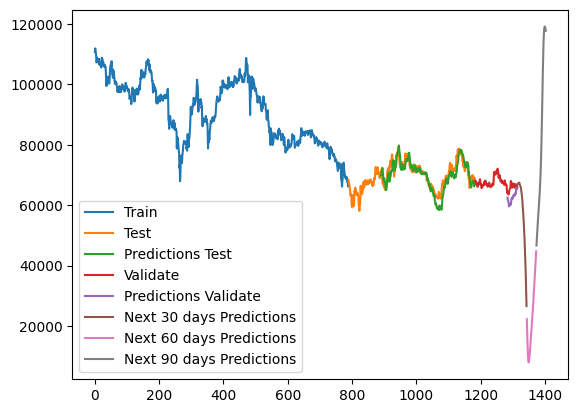

In [164]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()